In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
from owid import catalog

In this notebook we are cleaning and calculating youth mortality rate metrics. The source dataset is the UN Inter-agency Group for Child Mortality Estimation (UN IGME). The most recent dataset is available here: https://childmortality.org/data.

For one variable, 'Mortality rate age 5-14', the previous vintage of the dataset (2018) has a longer time-series back to 1950. In the current vintage the earliest datapoint is 1990 for this variable. The two time-series seem to be continuations of each other, therefore in this notebook we combine these two vintages together for this variable. When there are datapoints available for overlapping years we use the datapoint from the most recent vintage.

Furthermore, in this notebook we calculate additional youth mortality rates. 

Alongside the existing mortality rates:

* Neonatal mortality rate (0-27 days)
* Infant mortality rate (0-364 days) 
* Under-five mortality rate

We calculate:

* Under-ten mortality rate
* Under-fifteen mortality rate
* Under-twenty mortality rate
* Under-twenty five mortality rate



Firstly we read in current vintage of the data directly from UN IGME's website. Set the 'year' to the vintage of the most recent data. 

In [83]:
df = pd.read_csv('https://childmortality.org/wp-content/uploads/2021/09/UNIGME-2021.csv')
df.to_csv('data/input/un_igme_youth_mortality_input_data.csv.zip', index = False, compression='gzip')
year = 2021

/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/3990189567.py:1: DtypeWarning: Columns (6,9,10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://childmortality.org/wp-content/uploads/2021/09/UNIGME-2021.csv')


Read in the older version of this dataset which has a longer time-series for the 5-14 years mortality rate variable. We filter the data so that we only have datapoints that are used in the UN IGME estimate and for the 'Mortality rate age 5 to 14' variable. Then we check that we only have one value per country-year pair.

In [84]:
zip_file = ZipFile('data/input/Child Mortality Estimation.csv.zip')
old_df = pd.read_csv(zip_file.open('Child Mortality Estimation.csv'))
old_df = old_df[(old_df['SERIES_NAME_NAME'] == 'UN IGME estimate') & (old_df['INDICATOR_NAME'] == 'Mortality rate age 5 to 14')]
assert old_df[['REF_AREA_NAME', 'TIME_PERIOD']].duplicated().sum() == 0

Adding the vintage to the 5-14 MR age variable so it makes it clear which is which when we combine vintages. 

In [85]:
old_df.replace({'INDICATOR_NAME': {'Mortality rate age 5 to 14': 'Mortality rate age 5-14 (2018)'}}, inplace=True)

Selecting out only the columns we are going to be using. The TIME_PERIOD column has a month associated with each year, we will only use the year and therefore take the first four characters and convert them to numeric type. We also check all the values are between 1950 and the current vintage year. 

We also rename the columns to match the current vintage dataset. 

In [86]:
old_df = old_df[['REF_AREA_NAME', 'INDICATOR_NAME', 'TIME_PERIOD', 'OBS_VALUE']]
old_df['year'] = old_df['TIME_PERIOD'].str[:4].astype(int)
assert all((old_df['year'] >= 1950) & (old_df['year'] <= year))
old_df.drop(columns = ['TIME_PERIOD'], inplace = True)
old_df.columns = ['Country', 'Indicator', 'OBS_VALUE','year']
old_df

,Country,Indicator,OBS_VALUE,year
724,Afghanistan,Mortality rate age 5-14 (2018),50.4,1977
725,Afghanistan,Mortality rate age 5-14 (2018),46.9,1978
727,Afghanistan,Mortality rate age 5-14 (2018),43.7,1979
728,Afghanistan,Mortality rate age 5-14 (2018),40.5,1980
729,Afghanistan,Mortality rate age 5-14 (2018),37.7,1981
...,...,...,...,...
238661,Zimbabwe,Mortality rate age 5-14 (2018),15.2,2013
238663,Zimbabwe,Mortality rate age 5-14 (2018),15.0,2014
238664,Zimbabwe,Mortality rate age 5-14 (2018),14.7,2015
238665,Zimbabwe,Mortality rate age 5-14 (2018),14.4,2016


In [87]:
df.head()

,Geographic area,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Regional group,TIME_PERIOD,OBS_VALUE,COUNTRY_NOTES,...,Age Group of Women,Time Since First Birth,DEFINITION,INTERVAL,Series Method,LOWER_BOUND,UPPER_BOUND,STATUS,YEAR_TO_ACHIEVE,Model Used
0,Afghanistan,Neonatal mortality rate,Total,Total,Multiple Indicator Cluster Survey 2003 (Direct),2003,NaN,1981-01,36.0,NaN,...,NaN,NaN,NaN,5.0,Survey/Census with Full Birth Histories,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Neonatal mortality rate,Total,Total,Multiple Indicator Cluster Survey 2003 (Direct),2003,NaN,1986-01,25.0,NaN,...,NaN,NaN,NaN,5.0,Survey/Census with Full Birth Histories,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,Neonatal mortality rate,Total,Total,Multiple Indicator Cluster Survey 2003 (Direct),2003,NaN,1991-01,18.9,NaN,...,NaN,NaN,NaN,5.0,Survey/Census with Full Birth Histories,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,Neonatal mortality rate,Total,Total,Multiple Indicator Cluster Survey 2003 (Direct),2003,NaN,1996-01,19.1,NaN,...,NaN,NaN,NaN,5.0,Survey/Census with Full Birth Histories,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Neonatal mortality rate,Total,Total,Multiple Indicator Cluster Survey 2003 (Direct),2003,NaN,2001-01,20.7,NaN,...,NaN,NaN,NaN,5.0,Survey/Census with Full Birth Histories,NaN,NaN,NaN,NaN,NaN


Now we move onto cleaning the current vintage dataset.

We only want data which:
* Is a UN IGME estimate
* For both sexes (Total)
* For all wealth quintiles (Total)
* Is one of the following variables: Neonatal mortality rate, Infant mortality rate, Under-five mortality rate, Mortality rate age 5-9, Mortality rate age 5-14, Mortality rate age 15-19, Mortality rate age 15-24, Mortality rate age 5-24

In [88]:
df_sel = df[(df['Series Name'] == 'UN IGME estimate')  & (df['Sex'] == 'Total') & (df['Wealth Quintile'] == 'Total') &  (df['Indicator'])]

We add the regional group as a suffix to the 'Geographic area' variable where necessary. To distinguish between institutional definitions of regions, e.g. Sub-Saharan Africa (UNICEF) and Sub-Saharan Africa (UN SDG)

In [89]:

df_sel.replace({'Regional group': {'UNICEF': ' (UNICEF)', 'SDG': ' (UN SDG)', 'World bank': ' (WB)'}, 'Indicator':{'Mortality rate age 5-14':'Mortality rate age 5-14 (%d)' % (year)}}, inplace=True)
df_sel['Geographic area'] = df_sel[['Geographic area', 'Regional group']].fillna('').sum(axis=1)


/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/2256396197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.replace({'Regional group': {'UNICEF': ' (UNICEF)', 'SDG': ' (UN SDG)', 'World bank': ' (WB)'}, 'Indicator':{'Mortality rate age 5-14':'Mortality rate age 5-14 (%d)' % (year)}}, inplace=True)
/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/2256396197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel['Geographic area'] = df_sel[['Geographic area', 'Re

Select out only the columns we're interested in and convert the time-period to a year integer. The time-period is currently given as June in the year of the data.


Again, we select out only the columns we are going to be using. The TIME_PERIOD column has a month associated with each year, we will only use the year and therefore take the first four characters and convert them to numeric type. We also check all the values are between 1950 and the current vintage year. 

In [90]:
df_fil = df_sel[['Geographic area', 'Indicator', 'TIME_PERIOD', 'OBS_VALUE']]
df_fil['year'] = df_fil['TIME_PERIOD'].str[:4].astype(int)
assert all((old_df['year'] >= 1950) & (old_df['year'] <= year))
df_fil.drop(columns = ['TIME_PERIOD'], inplace = True)

/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/1201269012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil['year'] = df_fil['TIME_PERIOD'].str[:4].astype(int)
/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/1201269012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil.drop(columns = ['TIME_PERIOD'], inplace = True)


Standardising country names to Our World In Data country names.

In [91]:
df_fil.rename(columns = {'Geographic area':'Country'}, inplace = True)
countries = df_fil['Country'].drop_duplicates()
countries.to_csv('data/input/youth_mortality_countries_to_standardise.csv')

country_stan = pd.read_csv('data/input/youth_mortality_countries_to_standardise_country_standardized.csv')
country_stan = country_stan[['Country', 'Our World In Data Name']]



/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/2202594466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil.rename(columns = {'Geographic area':'Country'}, inplace = True)


In [92]:
df_fil_stan = df_fil.merge(country_stan, on = 'Country')
df_fil_stan.drop(columns = ['Country'], inplace = True)
df_fil_stan.rename(columns = {'Our World In Data Name':'Country'}, inplace = True)

Standardising country names of the 2018 dataset to Our World In Data country names.

In [93]:
old_df_stan = old_df.merge(country_stan, on = 'Country')
old_df_stan.drop(columns = ['Country'], inplace = True)
old_df_stan.rename(columns = {'Our World In Data Name':'Country'}, inplace = True)
old_df_stan.head()

,Indicator,OBS_VALUE,year,Country
0,Mortality rate age 5-14 (2018),50.4,1977,Afghanistan
1,Mortality rate age 5-14 (2018),46.9,1978,Afghanistan
2,Mortality rate age 5-14 (2018),43.7,1979,Afghanistan
3,Mortality rate age 5-14 (2018),40.5,1980,Afghanistan
4,Mortality rate age 5-14 (2018),37.7,1981,Afghanistan


Now we concatanate both vintages together

In [94]:
df_both = pd.concat([df_fil_stan, old_df_stan])
df_both.head()

,Indicator,OBS_VALUE,year,Country
0,Neonatal mortality rate,78.872785,1987,Afghanistan
1,Neonatal mortality rate,77.347279,1988,Afghanistan
2,Neonatal mortality rate,75.852975,1989,Afghanistan
3,Neonatal mortality rate,74.292026,1990,Afghanistan
4,Neonatal mortality rate,72.805546,1991,Afghanistan


We pivot the data so there is a column for each variable - each vintage of the 'Mortality rate age 5-14' should be shown separately.

In [95]:
df_piv = df_both.pivot(index =['Country','year'] , columns= 'Indicator' , values= 'OBS_VALUE').reset_index()

df_piv.head()

Indicator,Country,year,Child Mortality rate age 1-4,Child deaths age 1 to 4,Deaths 1-59 months,Deaths age 10 to 14,Deaths age 10 to 19,Deaths age 15 to 19,Deaths age 15 to 24,Deaths age 20 to 24,...,Mortality rate age 5-24,Mortality rate age 5-9,Neonatal deaths,Neonatal mortality rate,Progress towards SDG in neonatal mortality rate,Progress towards SDG in under-five mortality rate,Stillbirth rate,Stillbirths,Under-five deaths,Under-five mortality rate
0,Afghanistan,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377.841228
1,Afghanistan,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370.901556
2,Afghanistan,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364.407994
3,Afghanistan,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,358.205145
4,Afghanistan,1961,150.48637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,352.211995


We combine the 2018 vintage of the MR age 5-14 with the most recent vintage. For years where both vintages have a value we use the most recent vintage.

In [96]:
df_piv['Mortality rate age 5-14 (merged)']= df_piv['Mortality rate age 5-14 (%d)' % (year)].combine_first(df_piv['Mortality rate age 5-14 (2018)'])

Lets plot the three trends for Afghanistan to check they have merged as expected

In [97]:
df_plot =  df_piv[['year', 'Country', 'Mortality rate age 5-14 (merged)', 'Mortality rate age 5-14 (%d)' % (year), 'Mortality rate age 5-14 (2018)']]
df_plot = df_plot[df_plot['Country'] == 'Afghanistan']
max_mr = df_plot['Mortality rate age 5-14 (merged)'].max()+0.5

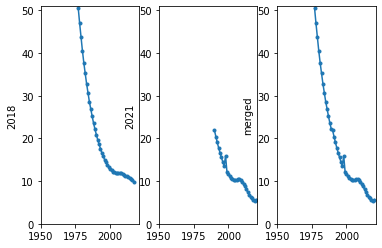

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(df_plot['year'], df_plot['Mortality rate age 5-14 (2018)'], '.-')
ax1.set_ylabel('2018')
ax1.set_xlim([1950, year])
ax1.set_ylim([0, max_mr])

ax2.plot(df_plot['year'], df_plot['Mortality rate age 5-14 (%d)' % (year)], '.-')
ax2.set_ylabel(year)
ax2.set_xlim([1950, year])
ax2.set_ylim([0, max_mr])

ax3.plot(df_plot['year'], df_plot['Mortality rate age 5-14 (merged)'], '.-')
ax3.set_ylabel('merged')
ax3.set_xlim([1950, year])
ax3.set_ylim([0, max_mr])

plt.show()

Now we move onto to calculating the new youth mortality rates. 

First of all we must adjusting the mortality rates, so that we can combine age groups together.

For example, if we want to calculate the mortality rate of under-tens then we need to combine the under-five mortality rate and the 5-9 year old age group. If there are 100 deaths per 1000 under fives, then we need to adjust the denominator of the 5-9 age group to take account of this. 

In [99]:
df_piv['Adjusted rate age 5-9'] = ((1000 - df_piv['Under-five mortality rate'])/1000) * df_piv['Mortality rate age 5-9']
df_piv['Under-ten mortality rate'] = df_piv['Under-five mortality rate'] + df_piv['Adjusted rate age 5-9']

df_piv['Adjusted rate age 5-14 (2018)'] = ((1000 - df_piv['Under-five mortality rate'])/1000 * df_piv['Mortality rate age 5-14 (2018)'])
df_piv['Under-fifteen mortality rate (2018)'] = df_piv['Under-five mortality rate'] + df_piv['Adjusted rate age 5-14 (2018)']

df_piv['Adjusted rate age 5-14 (%d)' % year] = ((1000 - df_piv['Under-five mortality rate'])/1000 * df_piv['Mortality rate age 5-14 (%d)' % year])
df_piv['Under-fifteen mortality rate (%d)' % year] = df_piv['Under-five mortality rate'] + df_piv['Adjusted rate age 5-14 (%d)' % year]

df_piv['Adjusted rate age 5-14 (merged)'] = ((1000 - df_piv['Under-five mortality rate'])/1000 * df_piv['Mortality rate age 5-14 (merged)'])
df_piv['Under-fifteen mortality rate (merged)'] = df_piv['Under-five mortality rate'] + df_piv['Adjusted rate age 5-14 (merged)']

df_piv['Adjusted rate age 15-19'] = ((1000 - df_piv['Under-fifteen mortality rate (merged)'])/1000 * df_piv['Mortality rate age 15-19'])
df_piv['Under-twenty mortality rate'] = df_piv['Under-fifteen mortality rate (merged)'] + df_piv['Adjusted rate age 15-19']

df_piv['Adjusted rate age 5-24'] = ((1000 - df_piv['Under-five mortality rate'])/1000 * df_piv['Mortality rate age 5-24'])
df_piv['Under-twenty-five mortality rate'] = df_piv['Under-five mortality rate'] + df_piv['Adjusted rate age 5-24']

Here we convert the mortality rates from being 'per 1000' to percentages. We also round to two decimal places at the same time and then select out only the columns we want to output. 

In [100]:
cols_dp = ['Child Mortality rate age 1-4','Mortality rate 1-59 months','Neonatal mortality rate', 'Mortality rate age 10-14',
       'Mortality rate age 10-19', 'Mortality rate age 15-19','Mortality rate age 15-24', 'Mortality rate age 20-24',
       'Mortality rate age 5-14 (2018)', 'Mortality rate age 5-14 (2021)','Mortality rate age 5-24', 'Mortality rate age 5-9',
       'Infant mortality rate','Under-five mortality rate', 'Under-ten mortality rate', 'Under-fifteen mortality rate (2018)',
       'Under-fifteen mortality rate (%d)' % year,'Under-fifteen mortality rate (merged)', 'Under-twenty mortality rate', 
       'Under-twenty-five mortality rate', 'Stillbirth rate']

cols_int = ['Child deaths age 1 to 4', 'Deaths 1-59 months', 'Deaths age 10 to 14',
       'Deaths age 10 to 19', 'Deaths age 15 to 19', 'Deaths age 15 to 24',
       'Deaths age 20 to 24', 'Deaths age 5 to 14', 'Deaths age 5 to 24',
       'Deaths age 5 to 9', 'Infant deaths','Neonatal deaths','Stillbirths', 'Under-five deaths']


df_piv[cols_dp] = round(df_piv[cols_dp]/10, 2) # the rates are calculated per 1,000, here we convert them to per 100 (i.e. a percentage)

df_piv[cols_int] = df_piv[cols_int].astype('Int64') # convert the deaths to integers
cols = ['Country', 'year'] + cols_dp + cols_int

df_piv_stan = df_piv[cols]

In [101]:
df_piv_stan['Under-fifteen deaths'] = df_piv_stan['Under-five deaths'] + df_piv_stan['Deaths age 5 to 14']

/var/folders/rz/kpg1phc51j5czjqsdmq8fttc0000gn/T/ipykernel_29076/3573748333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_piv_stan['Under-fifteen deaths'] = df_piv_stan['Under-five deaths'] + df_piv_stan['Deaths age 5 to 14']


In [102]:
df_piv_stan.columns


Index(['Country', 'year', 'Child Mortality rate age 1-4',
       'Mortality rate 1-59 months', 'Neonatal mortality rate',
       'Mortality rate age 10-14', 'Mortality rate age 10-19',
       'Mortality rate age 15-19', 'Mortality rate age 15-24',
       'Mortality rate age 20-24', 'Mortality rate age 5-14 (2018)',
       'Mortality rate age 5-14 (2021)', 'Mortality rate age 5-24',
       'Mortality rate age 5-9', 'Infant mortality rate',
       'Under-five mortality rate', 'Under-ten mortality rate',
       'Under-fifteen mortality rate (2018)',
       'Under-fifteen mortality rate (2021)',
       'Under-fifteen mortality rate (merged)', 'Under-twenty mortality rate',
       'Under-twenty-five mortality rate', 'Stillbirth rate',
       'Child deaths age 1 to 4', 'Deaths 1-59 months', 'Deaths age 10 to 14',
       'Deaths age 10 to 19', 'Deaths age 15 to 19', 'Deaths age 15 to 24',
       'Deaths age 20 to 24', 'Deaths age 5 to 14', 'Deaths age 5 to 24',
       'Deaths age 5 to 9', 'In

Save the output for uploading to grapher. 

In [103]:

df_piv_stan.to_csv('data/output/un_igme_youth_mortality_out_%d.csv' % year, index = False)